In [6]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

In [7]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 688 ms, sys: 75 ms, total: 763 ms
Wall time: 2.58 s


(1100, 1)

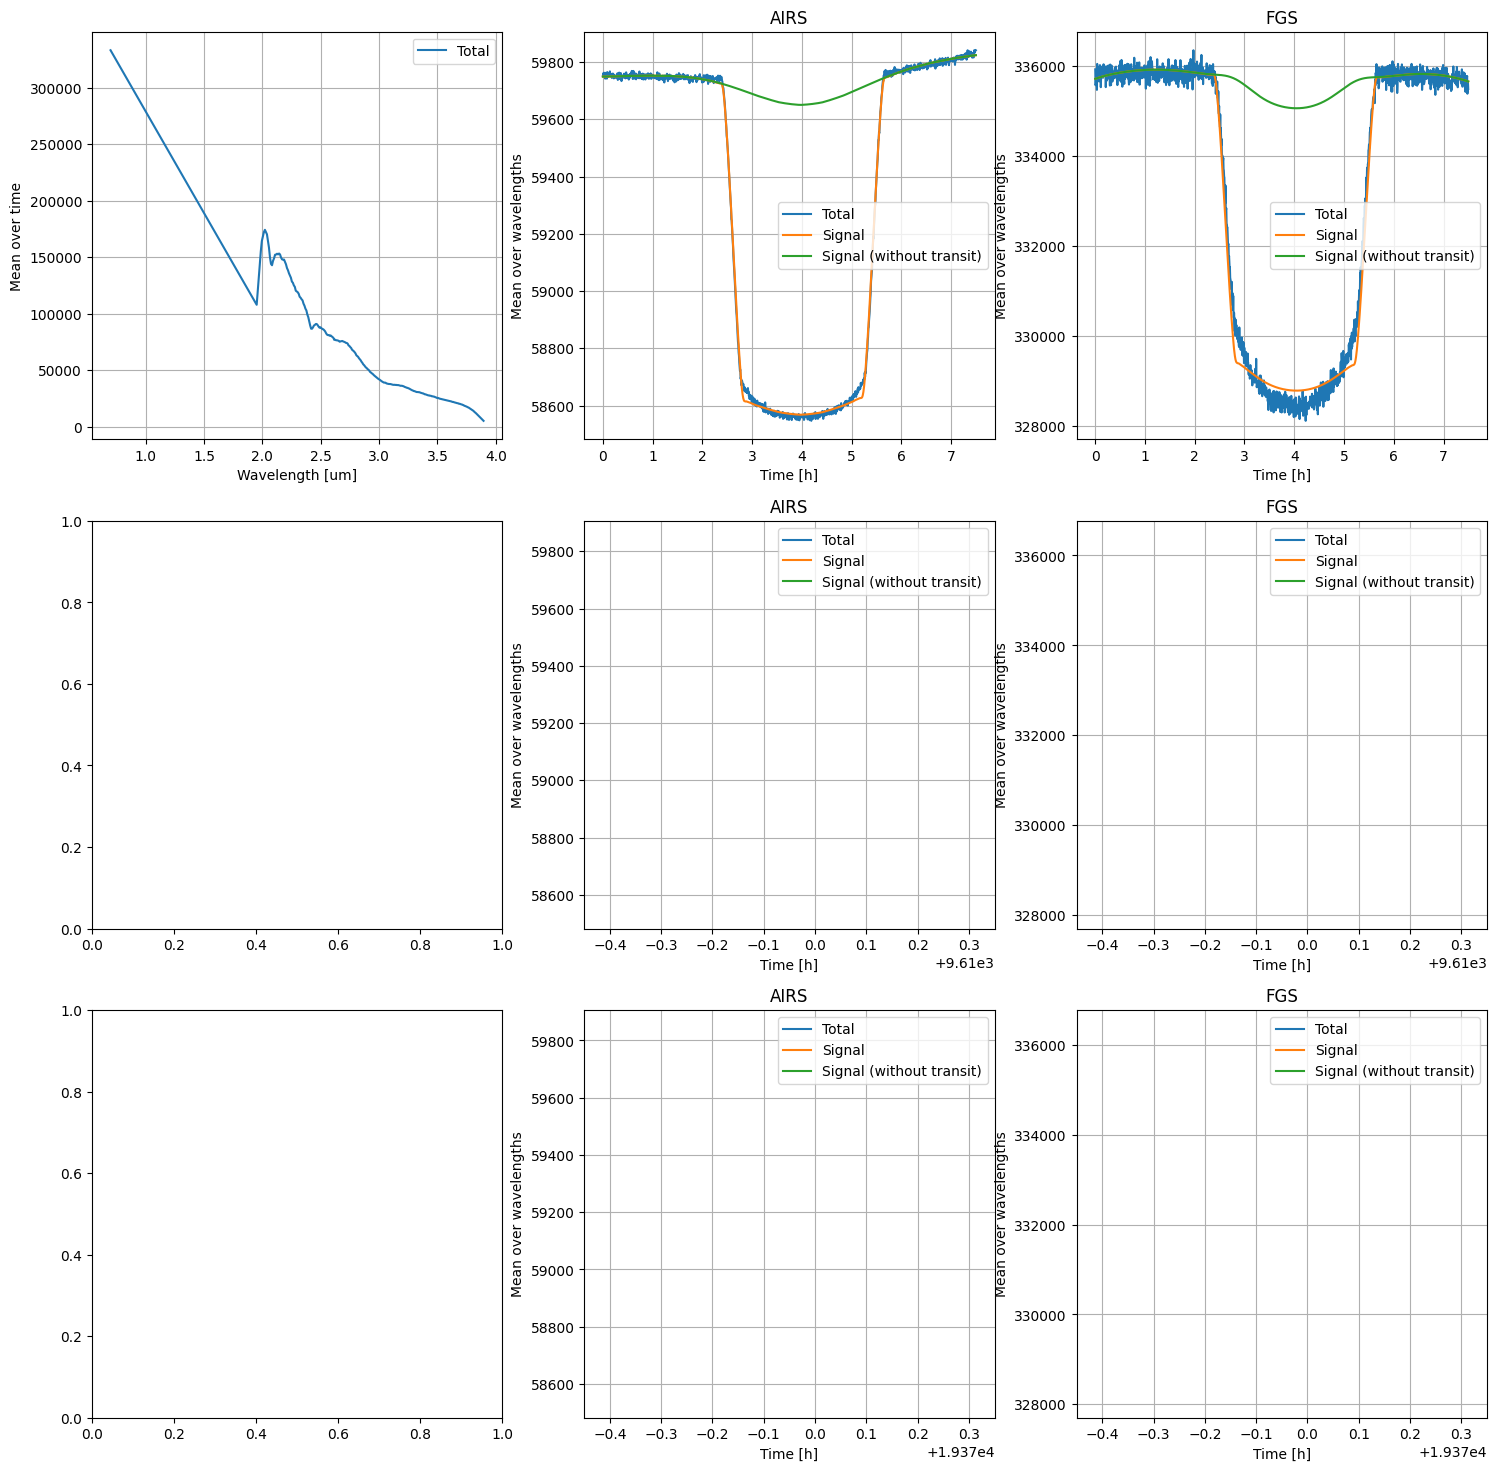

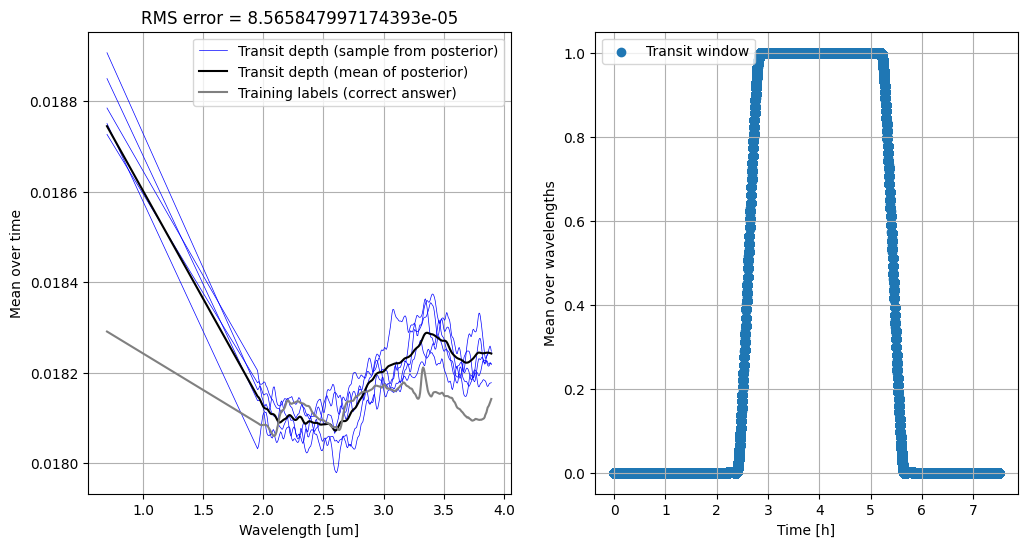

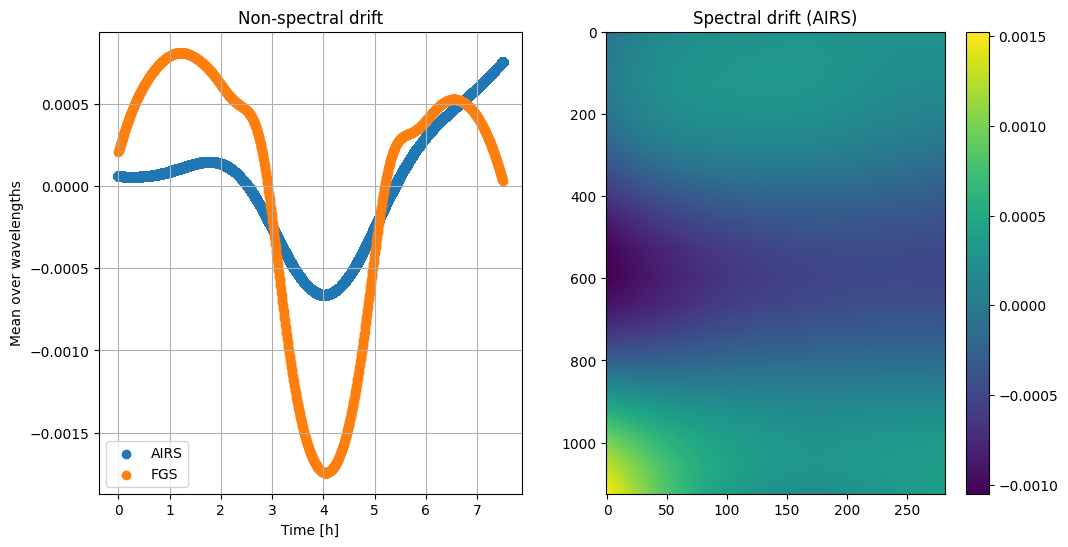

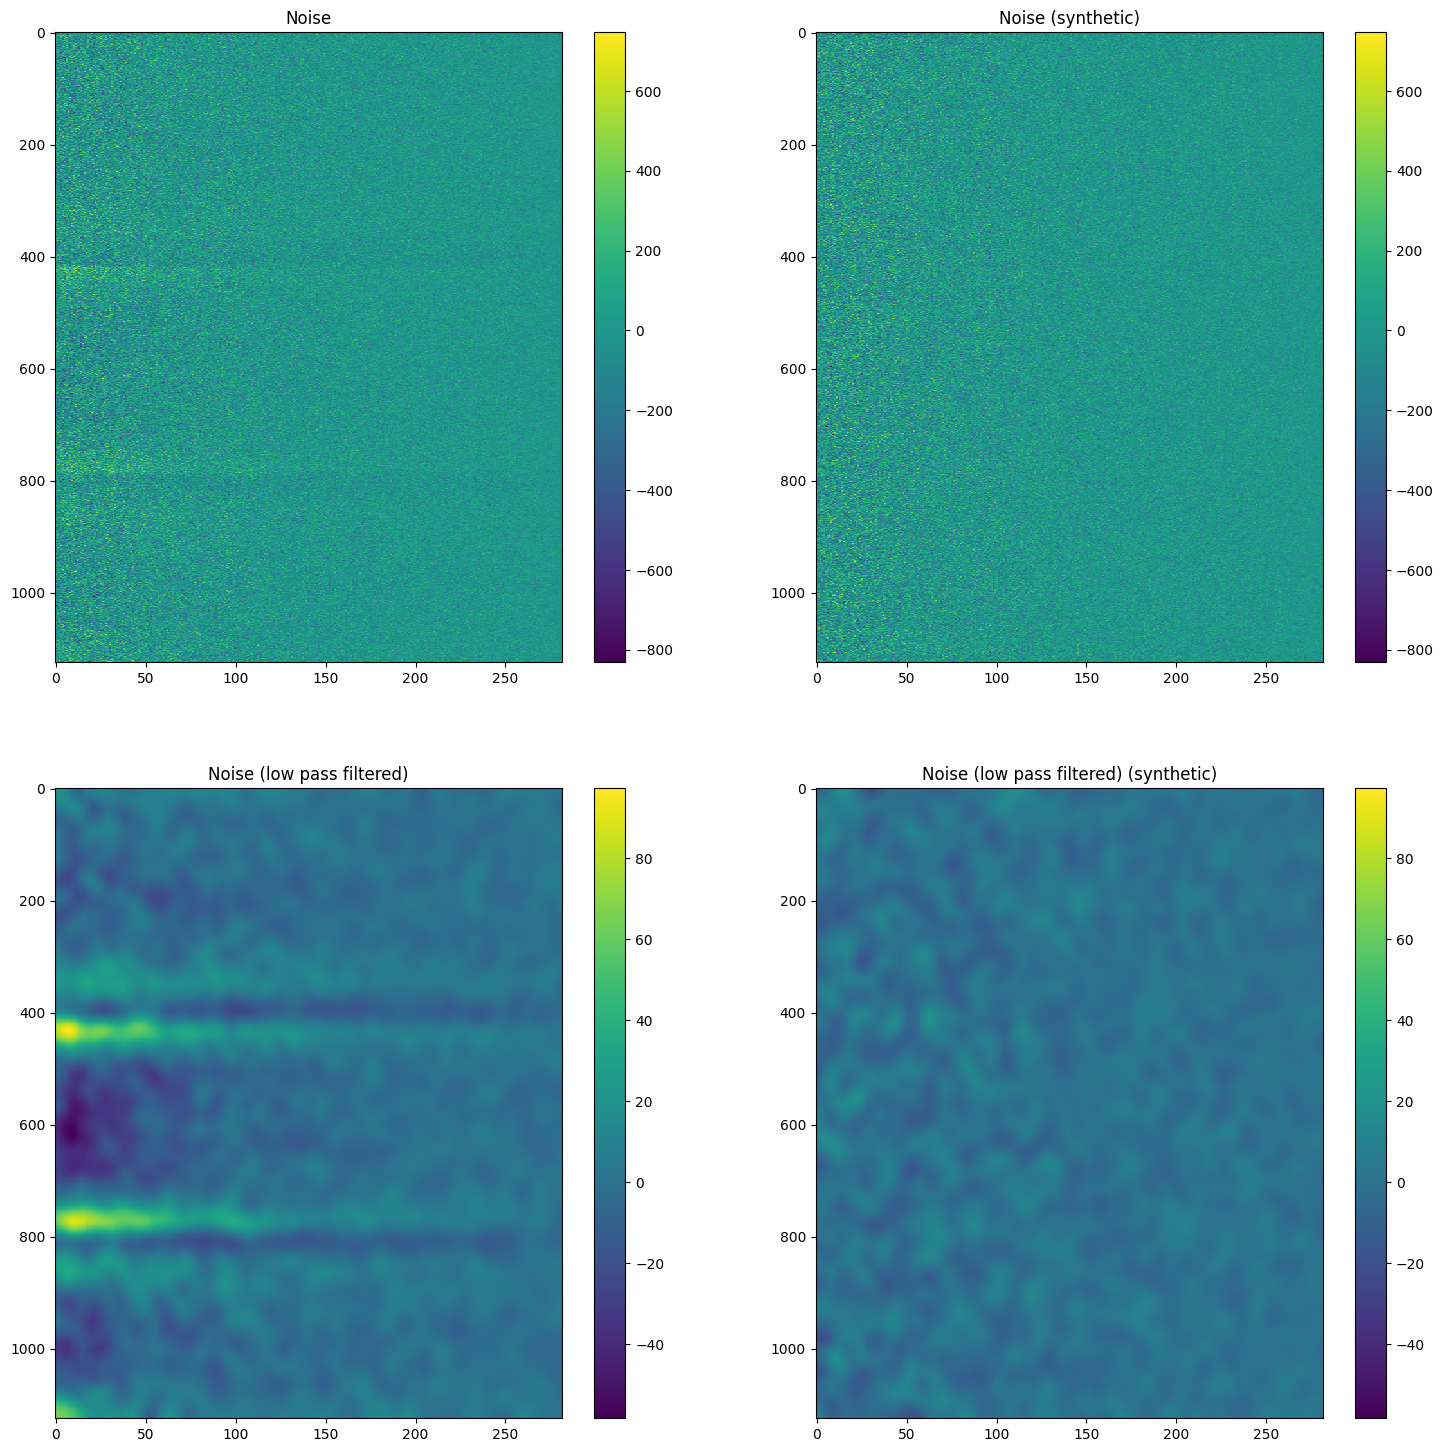

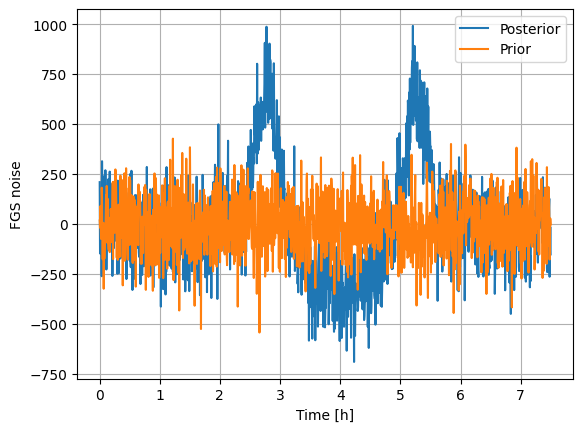

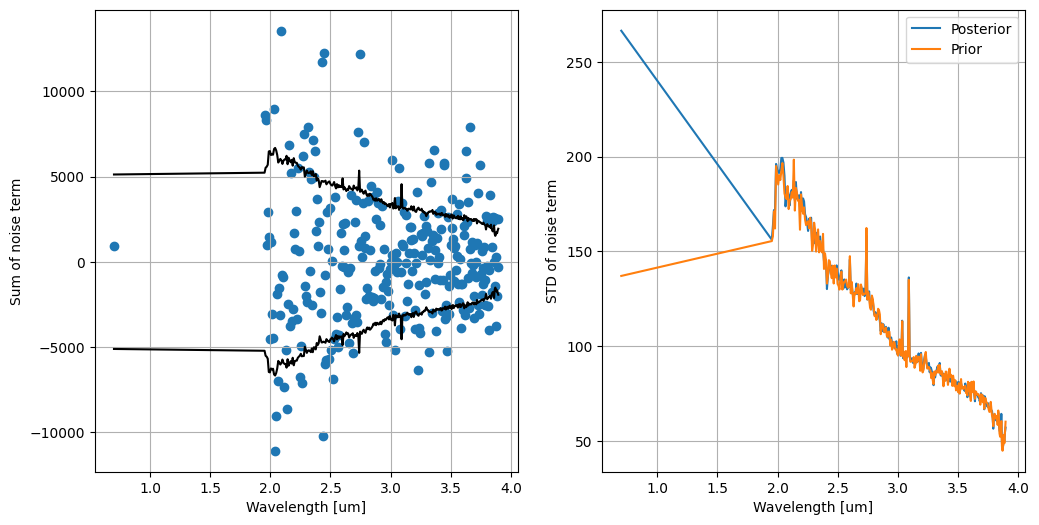

Score:          -0.9996
RMS error FGS:  453.82 ppm
RMS error AIRS: 81.44 ppm
Score:          -1.2641
RMS error FGS:  145.91 ppm
RMS error AIRS: 368.99 ppm
CPU times: user 6min 47s, sys: 23.5 s, total: 7min 11s
Wall time: 1min 28s


(-1.2641425528247072, 0.00014591356634155797, 0.0003689854898381332)

In [8]:
%%time
import gp
import ariel_gp
kgs.profiling=False
kgs.debugging_mode=2
importlib.reload(gp)
importlib.reload(ariel_gp)
model = ariel_gp.PredictionModel()  
model.run_in_parallel=False
model.model_options.n_iter = 7
model.plot_final = True
model.train(train_data)
model.starter_model.loaders[0].cache_steps = [5]
model.loaders[0].cache_steps = []
data = train_data[:1]
inferred_data = model.infer(data)
kgs.score_metric(inferred_data, data)
inferred_data_simple = model.starter_model.infer(data)
kgs.score_metric(inferred_data_simple, data)

In [5]:
%debug

> /mnt/d/ariel2/code/core/gp.py(197)get_prior_matrices()
    195             diff_actual = pred2-pred1
    196             diff_pred =  prior_matrices.design_matrix@offset
--> 197             assert np.all(np.abs(diff_actual - diff_pred)<=1e-5*np.abs(diff_actual+diff_pred)+1e-8*self.expected_observation_scale)
    198 
    199         return prior_matrices



ipdb>  np.abs(diff_actual - diff_pred) / (1e-5*np.abs(diff_actual+diff_pred)+1e-8*self.expected_observation_scale)


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])


ipdb>  np.max(np.abs(diff_actual - diff_pred) / (1e-5*np.abs(diff_actual+diff_pred)+1e-8*self.expected_observation_scale))


1.6725565293652307


ipdb>  self


TransitWindowModel(comment='.signal.transit.transit_window')


ipdb>  self.parameters


array([[1.13054167],
       [6.38609722],
       [0.        ]])


ipdb>  q
